In [0]:
# !pip install tensorflow-gpu==2.0.0-beta1
# !pip install 'tensorflow-hub == 0.5'


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

print(tf.__version__)

1.14.0


In [2]:
zip_file = tf.keras.utils.get_file(origin='https://storage.googleapis.com/plantdata/PlantVillage.zip', 
                                   fname='PlantVillage.zip', extract=True)


856842240/856839084 [==============================] - 16s 0us/step


In [0]:
data_dir = os.path.join(os.path.dirname(zip_file), 'PlantVillage')
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')

In [0]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"


In [5]:
print(' training :', count(train_dir))
print('validation :', count(validation_dir))


 training : /root/.keras/datasets/PlantVillage/train : 43444files
validation : /root/.keras/datasets/PlantVillage/validation : 10861files


In [6]:
!!wget https://github.com/obeshor/Plant-Diseases-Detector/archive/master.zip
!unzip master.zip;

Archive:  master.zip
271c9679637c76c68fb6886d31d8a1bfcf216638
   creating: Plant-Diseases-Detector-master/
   creating: Plant-Diseases-Detector-master/GreenDoctor/
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.gitignore  
   creating: Plant-Diseases-Detector-master/GreenDoctor/.idea/
   creating: Plant-Diseases-Detector-master/GreenDoctor/.idea/codeStyles/
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/codeStyles/Project.xml  
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/codeStyles/codeStyleConfig.xml  
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/encodings.xml  
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/gradle.xml  
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/misc.xml  
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/runConfigurations.xml  
   creating: Plant-Diseases-Detector-master/GreenDoctor/app/
 extracting: Plant-Diseases-Detector-master/GreenDoctor/app/.gitignore  
  

In [7]:
import json

with open('Plant-Diseases-Detector-master/categories.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())
print ('classes are')  
print (classes)

classes are
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato

In [8]:
print('Number of classes:',len(classes))

Number of classes: 38


In [0]:


IMAGE_SHAPE = (224, 224)

BATCH_SIZE = 64 #@param {type:"integer"}

In [10]:
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE)
do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE)


Found 10861 images belonging to 38 classes.
Found 43444 images belonging to 38 classes.


In [11]:

model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(512),
  tf.keras.layers.LeakyReLU(alpha = 0.3),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])


W0725 13:59:38.350689 139960705402752 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
LEARNING_RATE = 0.001 #@param {type:"number"}
model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])



In [17]:

EPOCHS=5 #@param {type:"integer"}

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Epoch 1/5
678/678 [==============================] - 605s 892ms/step - loss: 0.3871 - acc: 0.8784 - val_loss: 0.2520 - val_acc: 0.9196
Epoch 2/5
678/678 [==============================] - 605s 892ms/step - loss: 0.3756 - acc: 0.8818 - val_loss: 0.2317 - val_acc: 0.9215
Epoch 3/5
678/678 [==============================] - 604s 891ms/step - loss: 0.3694 - acc: 0.8844 - val_loss: 0.2135 - val_acc: 0.9293
Epoch 4/5
678/678 [==============================] - 604s 891ms/step - loss: 0.3665 - acc: 0.8866 - val_loss: 0.1901 - val_acc: 0.9378
Epoch 5/5
678/678 [==============================] - 602s 888ms/step - loss: 0.3712 - acc: 0.8852 - val_loss: 0.2187 - val_acc: 0.9291


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  2257984   
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  655872    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      multiple                  0         
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  19494     
Total params: 2,933,350
Trainable params: 675,366
Non-trainable params: 2,257,984
________________________________________

range(0, 5)


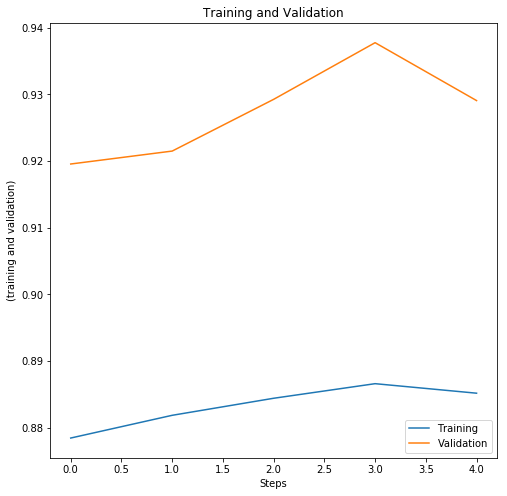

In [19]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)
print(epochs_range)

plt.figure(figsize=(8, 8))
plt.subplot(1, 1, 1)
plt.plot(epochs_range, acc, label='Training')
plt.plot(epochs_range, val_acc, label='Validation')
plt.legend(loc='lower right')
plt.title('Training and Validation') 
plt.ylabel("(training and validation)")
plt.xlabel("Steps")

plt.show()

In [0]:

import cv2
import itertools
import random
from collections import Counter
from glob import iglob
def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SHAPE[0], IMAGE_SHAPE[1]) )
    img = img /255
    return img
def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

Source class: Soybean___healthy, obtained from Soybean___healthy/4a6fe011-b9f9-4992-a7c5-eacaa62c3816___RS_HL 6014.JPG


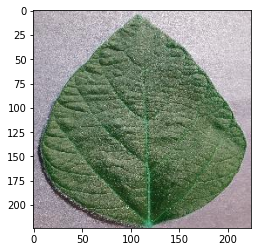

<Figure size 432x288 with 0 Axes>

estimated output Soybean___healthy, accuracy of outcome 0.999915
Source class: Tomato___Bacterial_spot, obtained from Tomato___Bacterial_spot/4ac4ef34-f2c2-4e08-a0d6-ad3d225159f5___GCREC_Bact.Sp 6177.JPG


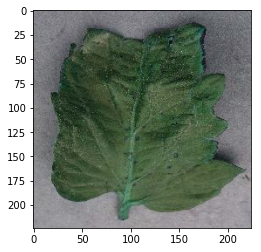

estimated output Tomato___Bacterial_spot, accuracy of outcome 0.933263
Source class: Apple___Black_rot, obtained from Apple___Black_rot/7add2e39-6555-4d52-ad02-b1bb061db8e7___JR_FrgE.S 3039.JPG


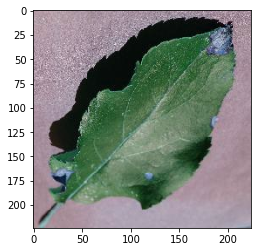

<Figure size 432x288 with 0 Axes>

estimated output Apple___Black_rot, accuracy of outcome 0.763232
Source class: Pepper,_bell___Bacterial_spot, obtained from Pepper,_bell___Bacterial_spot/21556c18-1833-43a9-86b2-8e7130b4dbce___JR_B.Spot 3230.JPG


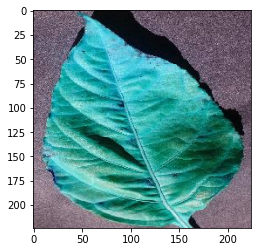

<Figure size 432x288 with 0 Axes>

estimated output Pepper,_bell___healthy, accuracy of outcome 0.992506
Source class: Orange___Haunglongbing_(Citrus_greening), obtained from Orange___Haunglongbing_(Citrus_greening)/20e4a0e9-69da-4d97-be4b-4830e6b88709___UF.Citrus_HLB_Lab 0224.JPG


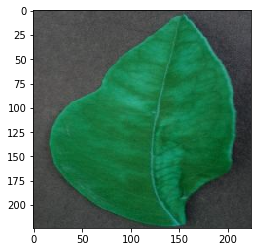

<Figure size 432x288 with 0 Axes>

estimated output Orange___Haunglongbing_(Citrus_greening), accuracy of outcome 0.974916


In [21]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("Source class: %s, obtained from %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()
    print("estimated output %s, accuracy of outcome %f" % (list(prediction.keys())[0], list(prediction.values())[0]))